# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096-iap17/blob/master/lecture1/Boxes-and-registers.ipynb.)

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [44]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Array{Float64,1}:
 0.38386  
 0.741867 
 0.616314 
 0.222634 
 0.930708 
 0.748937 
 0.664234 
 0.716229 
 0.43317  
 0.392717 
 0.482653 
 0.134352 
 0.787184 
 ⋮        
 0.331171 
 0.857401 
 0.419951 
 0.73747  
 0.758178 
 0.598816 
 0.431693 
 0.893903 
 0.691669 
 0.505111 
 0.754398 
 0.0118159

In [45]:
sum(a)

4.999847812477038e6

In [46]:
@time sum(a)

@time sum(a)

@time sum(a)


  0.008390 seconds (5 allocations: 176 bytes)
  0.005902 seconds (5 allocations: 176 bytes)
  0.008547 seconds (5 allocations: 176 bytes)


4.999847812477038e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

Julia has a `BenchmarkTools.jl` package for easy and accurate benchmarking:

In [47]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [48]:
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [49]:
c_sum(a)

4.999847812476703e6

In [50]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [51]:
c_sum(a) - sum(a)  

-3.3527612686157227e-7

In [52]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

In [53]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=sqrt(eps), atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= atol + rtol*max(norm(x), norm(y))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, `rtol` defaults to `sqrt(eps(typeof(real(x-y))))`. This corresponds to requiring equality of about half of the significand digits. For other types, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to `vecnorm` but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true
```

```
isapprox(x::FixedPoint, y::FixedPoint; rtol=0, atol=max(eps(x), eps(y)))
```

For FixedPoint numbers, the default criterion is that `x` and `y` differ by no more than `eps`, the separation between adjacent fixed-point numbers.


We can now benchmark the C code directly from Julia:

In [54]:
c_bench = @benchmark c_sum($a) 

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     12.781 ms (0.00% GC)
  median time:      16.719 ms (0.00% GC)
  mean time:        19.212 ms (0.00% GC)
  maximum time:     104.050 ms (0.00% GC)
  --------------
  samples:          260
  evals/sample:     1

In [55]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 12.780767 msec


In [56]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any,Any} with 1 entry:
  "C" => 12.7808

In [57]:
using Plots
gr()

Plots.GRBackend()

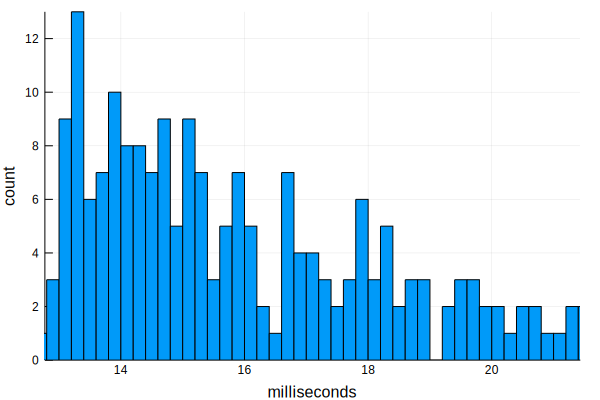

In [58]:
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [59]:
using PyCall

In [60]:
# Call a low-level PyCall function to get a Python list, because
# by default PyCall will convert to a NumPy array instead (we benchmark NumPy below):

apy_list = PyCall.array2py(a, 1, 1)

# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [61]:
pysum(a)

4.999847812476703e6

In [62]:
pysum(a) ≈ sum(a)

true

In [63]:
py_list_bench = @benchmark $pysum($apy_list)

BenchmarkTools.Trial: 
  memory estimate:  512 bytes
  allocs estimate:  17
  --------------
  minimum time:     152.673 ms (0.00% GC)
  median time:      181.490 ms (0.00% GC)
  mean time:        186.612 ms (0.00% GC)
  maximum time:     275.620 ms (0.00% GC)
  --------------
  samples:          27
  evals/sample:     1

In [64]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any,Any} with 2 entries:
  "C"               => 12.7808
  "Python built-in" => 152.673

# 3. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [65]:
using Conda

In [66]:
numpy_sum = pyimport("numpy")["sum"]
apy_numpy = PyObject(a) # converts to a numpy array by default

py_numpy_bench = @benchmark $numpy_sum($apy_numpy)

BenchmarkTools.Trial: 
  memory estimate:  720 bytes
  allocs estimate:  22
  --------------
  minimum time:     7.443 ms (0.00% GC)
  median time:      10.539 ms (0.00% GC)
  mean time:        11.692 ms (0.00% GC)
  maximum time:     60.088 ms (0.00% GC)
  --------------
  samples:          427
  evals/sample:     1

In [67]:
numpy_sum(apy_list) # python thing

4.999847812477041e6

In [68]:
numpy_sum(apy_list) ≈ sum(a)

true

In [69]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C"               => 12.7808
  "Python numpy"    => 7.44318
  "Python built-in" => 152.673

# 4. Python, hand-written 

In [70]:
py"""
def py_sum(a):
    s = 0.0
    for x in a:
        s = s + x
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x13a1cc0c8>

In [71]:
py_hand = @benchmark $sum_py($apy_list)

BenchmarkTools.Trial: 
  memory estimate:  512 bytes
  allocs estimate:  17
  --------------
  minimum time:     2.548 s (0.00% GC)
  median time:      3.048 s (0.00% GC)
  mean time:        3.048 s (0.00% GC)
  maximum time:     3.549 s (0.00% GC)
  --------------
  samples:          2
  evals/sample:     1

In [72]:
@which sum([1.5])

sum(a) in Base at reduce.jl:359

In [73]:
sum_py(apy_list)

4.999847812476703e6

In [74]:
sum_py(apy_list) ≈ sum(a)

true

In [75]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"                   => 12.7808
  "Python numpy"        => 7.44318
  "Python hand-written" => 2548.23
  "Python built-in"     => 152.673

# 5. Julia (built-in) 

## Written directly in Julia, not in C!

In [76]:
@which sum(a)

sum(a) in Base at reduce.jl:359

In [77]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     5.737 ms (0.00% GC)
  median time:      8.863 ms (0.00% GC)
  mean time:        9.004 ms (0.00% GC)
  maximum time:     23.159 ms (0.00% GC)
  --------------
  samples:          554
  evals/sample:     1

In [78]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "C"                   => 12.7808
  "Python numpy"        => 7.44318
  "Python hand-written" => 2548.23
  "Python built-in"     => 152.673
  "Julia built-in"      => 5.73662

# 6. Julia (hand-written) 

In [79]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(A))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [80]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     15.821 ms (0.00% GC)
  median time:      23.861 ms (0.00% GC)
  mean time:        23.148 ms (0.00% GC)
  maximum time:     40.402 ms (0.00% GC)
  --------------
  samples:          216
  evals/sample:     1

In [81]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "C"                   => 12.7808
  "Python numpy"        => 7.44318
  "Julia hand-written"  => 15.8212
  "Python hand-written" => 2548.23
  "Python built-in"     => 152.673
  "Julia built-in"      => 5.73662

# 7. Julia (hand-written w. simd) 

In [87]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [88]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     5.706 ms (0.00% GC)
  median time:      6.602 ms (0.00% GC)
  mean time:        7.279 ms (0.00% GC)
  maximum time:     27.573 ms (0.00% GC)
  --------------
  samples:          685
  evals/sample:     1

In [89]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any,Any} with 7 entries:
  "Julia hand-written simd" => 5.70581
  "C"                       => 12.7808
  "Python numpy"            => 7.44318
  "Julia hand-written"      => 15.8212
  "Python hand-written"     => 2548.23
  "Python built-in"         => 152.673
  "Julia built-in"          => 5.73662

# Summary

In [91]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value, 1), 6, "."))
end

Julia hand-written simd.....5.7
Julia built-in..............5.7
Python numpy................7.4
C..........................12.8
Julia hand-written.........15.8
Python built-in...........152.7
Python hand-written......2548.2
